# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PIL import Image, ImageDraw

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(sys.path)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/nvinden/Projects/tulpan/Mask_RCNN
['/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python36.zip', '/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6', '/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6/lib-dynload', '', '/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6/site-packages', '/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg', '/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6/site-packages/IPython/extensions', '/home/nvinden/.ipython', '/home/nvinden/Projects/tulpan/Mask_RCNN']


Using TensorFlow backend.


## Configurations

In [2]:
class CowConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes
    # (COW, PIG, PLATE)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CowConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class CutsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    
    data_path = "/home/nvinden/Projects/tulpan/imagej2coco/coco_out"

    def load_shapes(self, split = "train"):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        
        assert split in ["train", "test", "val"]
        
        # Add classes
        self.add_class("shapes", 1, "marbling")
        self.add_class("shapes", 2, "clean lean")
        self.add_class("shapes", 3, "cropped")
        self.add_class("shapes", 4, "blobEtc")
        self.add_class("shapes", 5, "specular")
        self.add_class("shapes", 6, "fat area")
        self.add_class("shapes", 7, "circle fat")
        self.add_class("shapes", 8, "no Blob")
        self.add_class("shapes", 9, "no Specular")
        self.add_class("shapes", 10, "base")
        self.add_class("shapes", 11, "thrsh shrunk")
        self.add_class("shapes", 12, "circle cropped")
        self.add_class("shapes", 13, "bruiseEtc")
        self.add_class("shapes", 14, "new shrunk")
        self.add_class("shapes", 15, "shrunk")
        self.add_class("shapes", 16, "base circle")
        
        # Create file tuple with all of the files ordered alphabetically. We use this for file
        # indexes
        self.file_list = [f.replace(".json", "") for f in os.listdir(os.path.join(self.data_path, split)) if os.path.isfile(os.path.join(self.data_path, split, f)) and ".json" in f]
        self.file_list = tuple(self.file_list)

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for img_id in self.file_list:
            json_path = os.path.join(self.data_path, split, img_id + ".json")
            
            with open(json_path) as user_file:
                json_data = json.load(user_file)
                
            # Get Height and Width of image.
            if os.path.isfile(os.path.join(self.data_path, split, img_id + ".jpg")):
                img_path = os.path.join(self.data_path, split, img_id + ".jpg")
                with Image.open(img_path) as im:
                    width, height = im.size
            elif os.path.isfile(os.path.join(self.data_path, split, img_id + ".JPG")):
                img_path = os.path.join(self.data_path, split, img_id + ".JPG")
                with Image.open(img_path) as im:
                    width, height = im.size
            
            self.add_image("shapes", image_id = img_id, json_path = json_path,
                           path = img_path, width = width, height = height, 
                           polygons = json_data['shapes'])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        img_path = info["path"]
        with Image.open(img_path) as img:
            image = np.array(img)

        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        polygons = info["polygons"]
        
        count = len(polygons)
        
        mask_list = list()
        class_ids = list()
        
        for i, instance in enumerate(polygons):
            label = instance["label"]
            points = instance["points"]
            points = [tuple(point) for point in points]
            
            label_index = self.class_names.index(label)
            
            img = Image.new('L', (info['width'], info['height']), 0)
            ImageDraw.Draw(img).polygon(points, outline=1, fill=1)
            mask = np.array(img)
            
            # TODO: FIX THIS TO TURN (3, 200, 300) -> (200, 300, 3) for exmaple
            mask.astype(np.bool)
            
            mask_list.append(mask)
            class_ids.append(label_index)
        
        mask_list = np.array(mask_list).astype(np.bool)
        #print(mask_list, class_ids)
        mask_list = np.transpose(mask_list, [1, 2, 0])
        class_ids = np.array(class_ids).astype(np.int32)
        
        return mask_list.astype(np.bool), class_ids.astype(np.int32)

In [5]:
# Training dataset
dataset_train = CutsDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
#dataset_val = CutsDataset()
#dataset_val.load_shapes("val")
#dataset_val.prepare()

(3000, 4000, 1)
(3000, 4000, 3)


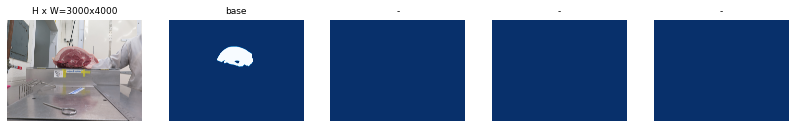

(3000, 4000, 1)
(3000, 4000, 3)


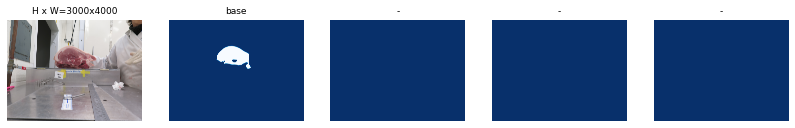

(3000, 4000, 1)
(3000, 4000, 3)


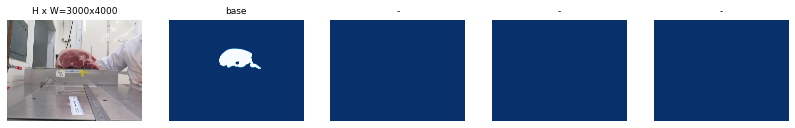

(3000, 4000, 1)
(3000, 4000, 3)


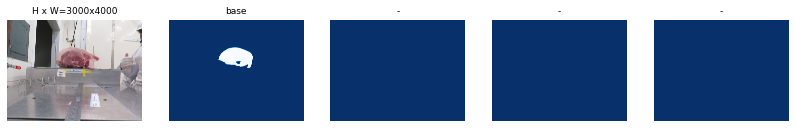

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

MASK RCNN INITIATED


In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/nvinden/Projects/tulpan/Mask_RCNN/logs/shapes20230130T1217/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/nvinden/anaconda3/envs/tf1_maskrcnn/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
  3/100 [..............................] - ETA: 7982s - loss: 5.7297 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.4785 - mrcnn_class_loss: 1.1084 - mrcnn_bbox_loss: 0.9909 - mrcnn_mask_loss: 2.0835

Process Process-3:
Process Process-2:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [35]:
class InferenceConfig(CowConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

MASK RCNN INITIATED


FileNotFoundError: [Errno 2] Could not find weight files in /home/nvinden/Projects/tulpan/Mask_RCNN/logs/shapes20230130T1217

In [39]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

IndexError: list index out of range

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


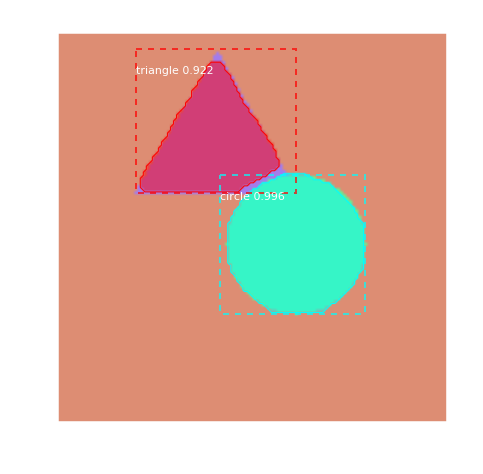

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
